# Präsenzversuch zum Laval-Rotor

Name:Moritz Roth
Datum:5.02.2024  
Gruppe:12

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: In wie weit weicht die experimentell bestimmte Eigenfrequenz von der vorab berechneten Eigenfrequenz ab? Wie stark beeinflusst die Scheiebenanzahl die Eigenfreuenz? Wie gut lassen sich die Vibrationen/Schwingungen des Veruchs in der Auswertung darstellen?

## Erster Versuch: Prüfstand #3
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="pictures_lab/Versuchsaufbau_labor.jpg" width="800">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Der Prüfstand besteht aus einer Welle, welche mit hilfe eines Fest und eines Loslagers gelagert sind. Auf der 0,75m langen und 10 mm starken Welle befindet sich eine Scheibe mit einer Masse von 950g. Kurz hinter der Scheibe ist noch ein "Wellenfangkorb" angebracht der bei einem unvorhergesehen Missgeschick die sich lösende Welle aufhalten würde und somit den bediehner schützt. Auf der rechten Seite des Prüfstandes war ein Elektromotor mit der Welle verbunden, der für die nötigen Umdrehungen sorgt. Dieser Elektromotor wird von einem Pi gesteuert. Am Festlager, welches die Welle fixiert, sitzt zusätzlich noch ein Beschleunigungssensor, welcher die auftretende Schwingungen/Vibrationen misst.

### Versuchsauswertung

In [7]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [8]:
path_measurement_folder = os.path.join("/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240123_140859_lavalrotor_12_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [9]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalroto

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [10]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [11]:
importlib.reload(m_postprocessing)  # reload functions

#Pfad zu h5 datei
h5_file_path = "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/data_20240123_140859_lavalrotor_12_03.h5"#"f"{path_measurement_folde}/{filename}"#"/

#Datenlisten von h5 Datei
#acceleration_x =[]
#acceleration_y =[]
#acceleration_z =[]
#time =[]
rpm =[]

acc_inter = []
amplitude_spectrums = []
frequencies = []

#h5 Datei auslesen 
with h5py.File(h5_file_path, "r") as file:
    for exp_stamp in file.keys():
        experiment_group = file[exp_stamp]["RawData"]#auslesen aller 20 messpunkte per schleife

        data_group = experiment_group[uuid_acceleration]
        acceleration_x = np.array(data_group["acceleration_x"])
        acceleration_y = np.array(data_group["acceleration_y"])
        acceleration_z = np.array(data_group["acceleration_z"])
        time = np.array(data_group["timestamp"])
        
        rpm_point = experiment_group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_point/60)
        #verwendung der postprocessing fkts
        acc_point = m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
        acc_interpolated = m_postprocessing.interpolation(time,acc_point,interpolation_points)
        acc_inter.append(acc_interpolated)
        amplitude_spectrum_point, frequency_point = m_postprocessing.my_fft_scaled(acc_interpolated, interpolation_points)
        amplitude_spectrums.append(amplitude_spectrum_point[1:])
        frequencies.append(frequency_point[1:])
        #print(acc_interpolated)   

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

<function matplotlib.pyplot.show(close=None, block=None)>

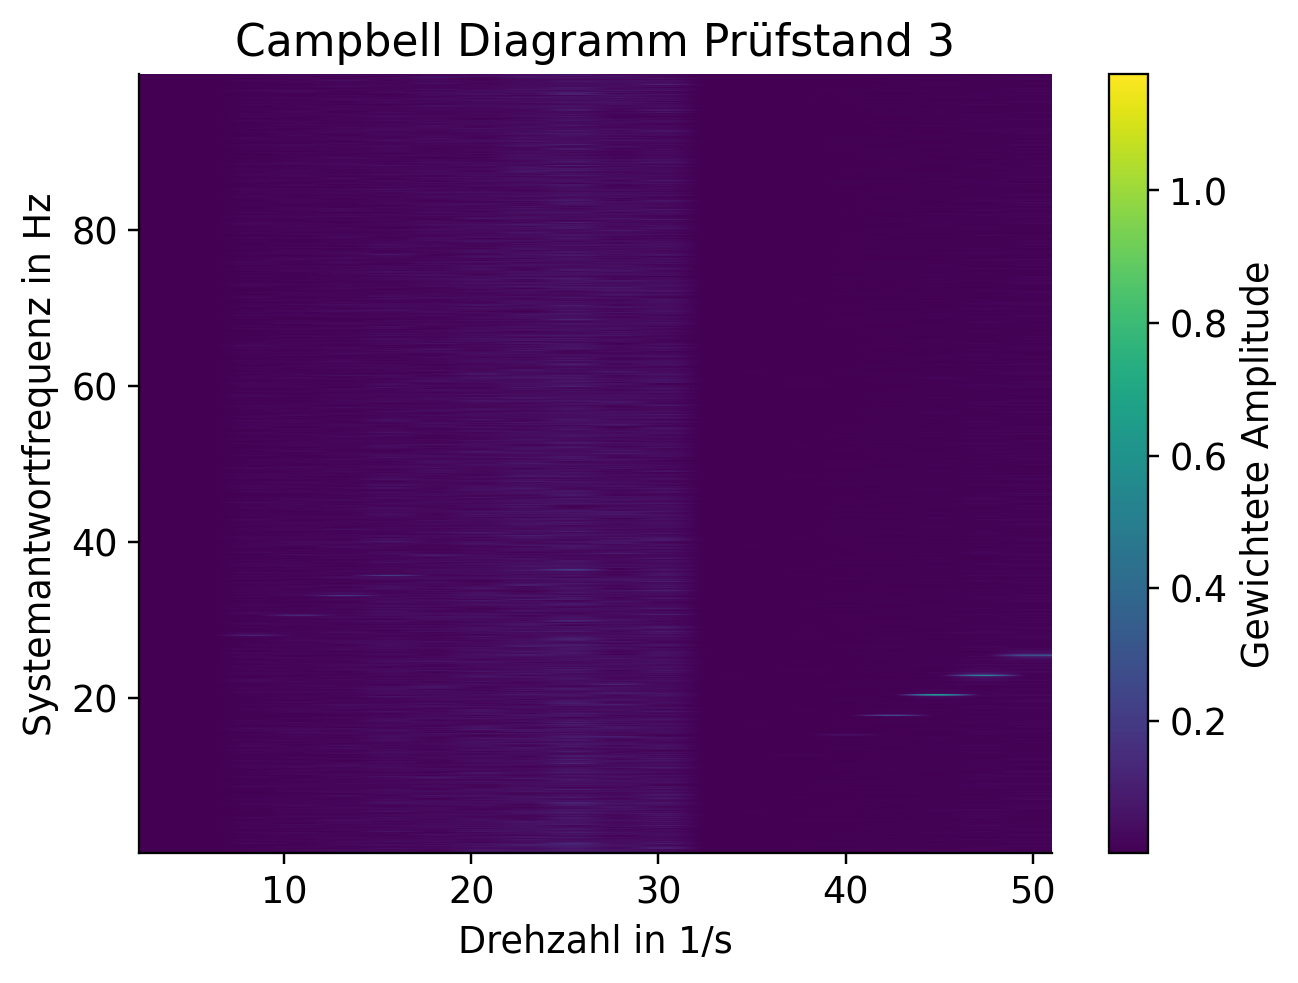

In [12]:

amplitude_spectrums_array = np.array(amplitude_spectrums)
frequencies_array = np.array(frequencies)
rpm_array = np.array(rpm)

#Erstellen Sie eine leere Matrix für die Verlaufsdarstellung
Amp_matrix = np.zeros((len(frequencies_array[0]),len(rpm_array) ))

#Iterieren Sie über jede Zeile der Matrix von der Verlaufsdarstellung und füllt Sie sie mit den Amplitudenwerten
for i in range(len(rpm_array)):
    for j in range(len(frequencies_array[i])):
        Amp_matrix[j, i] += amplitude_spectrums_array[i, j]

#Diagramm erstellen
fig = plt.figure()
plt.imshow(Amp_matrix, aspect='auto', origin='lower', extent=[rpm_array.min(), rpm_array.max(),frequencies_array.min(), frequencies_array.max()], vmin=Amp_matrix.min(), vmax=Amp_matrix.max(), cmap='viridis')
plt.title('Campbell Diagramm Prüfstand 3')
plt.xlabel('Drehzahl in 1/s')
plt.ylabel('Systemantwortfrequenz in Hz')
plt.colorbar(label='Gewichtete Amplitude')
plt.show

## Zweiter Datensatz: Prüfstand #2

#### 1. Einlesen der Mess- und Metadaten

In [20]:
#1a angabe Pfad/Dateiname
path_measurement_folder = os.path.join("/home/pi/lavalrotor_laboratory/measurement_data/data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file
 
#1b auslesen Metadaten
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240102_100928_lavalroto

#### 2. Verarbeitung der Messdaten

In [21]:
importlib.reload(m_postprocessing)  # reload functions

#Pfad zu h5 datei
h5_file_path = "/home/pi/lavalrotor_laboratory/measurement_data/data_20240102_100928_lavalrotor_01_02/data_20240102_100928_lavalrotor_01_02.h5"#"f"{path_measurement_folde}/{filename}"#"/

#Datenlisten von h5 Datei
#acceleration_x =[]
#acceleration_y =[]
#acceleration_z =[]
#time =[]
rpm =[]

acc_inter = []
amplitude_spectrums = []
frequencies = []

#h5 Datei auslesen 
with h5py.File(h5_file_path, "r") as file:
    for exp_stamp in file.keys():
        experiment_group = file[exp_stamp]["RawData"]#auslesen aller 20 messpunkte per schleife

        data_group = experiment_group[uuid_acceleration]
        acceleration_x = np.array(data_group["acceleration_x"])
        acceleration_y = np.array(data_group["acceleration_y"])
        acceleration_z = np.array(data_group["acceleration_z"])
        time = np.array(data_group["timestamp"])
        
        rpm_point = experiment_group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_point/60)
        #verwendung der postprocessing fkts
        acc_point = m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
        acc_interpolated = m_postprocessing.interpolation(time,acc_point,interpolation_points)
        acc_inter.append(acc_interpolated)
        amplitude_spectrum_point, frequency_point = m_postprocessing.my_fft_scaled(acc_interpolated, interpolation_points)
        amplitude_spectrums.append(amplitude_spectrum_point[1:])
        frequencies.append(frequency_point[1:])
        ##print(max(amplitude_spectrum_point))

#### 3. Darstellung mittels Campbell-Diagramm

<function matplotlib.pyplot.show(close=None, block=None)>

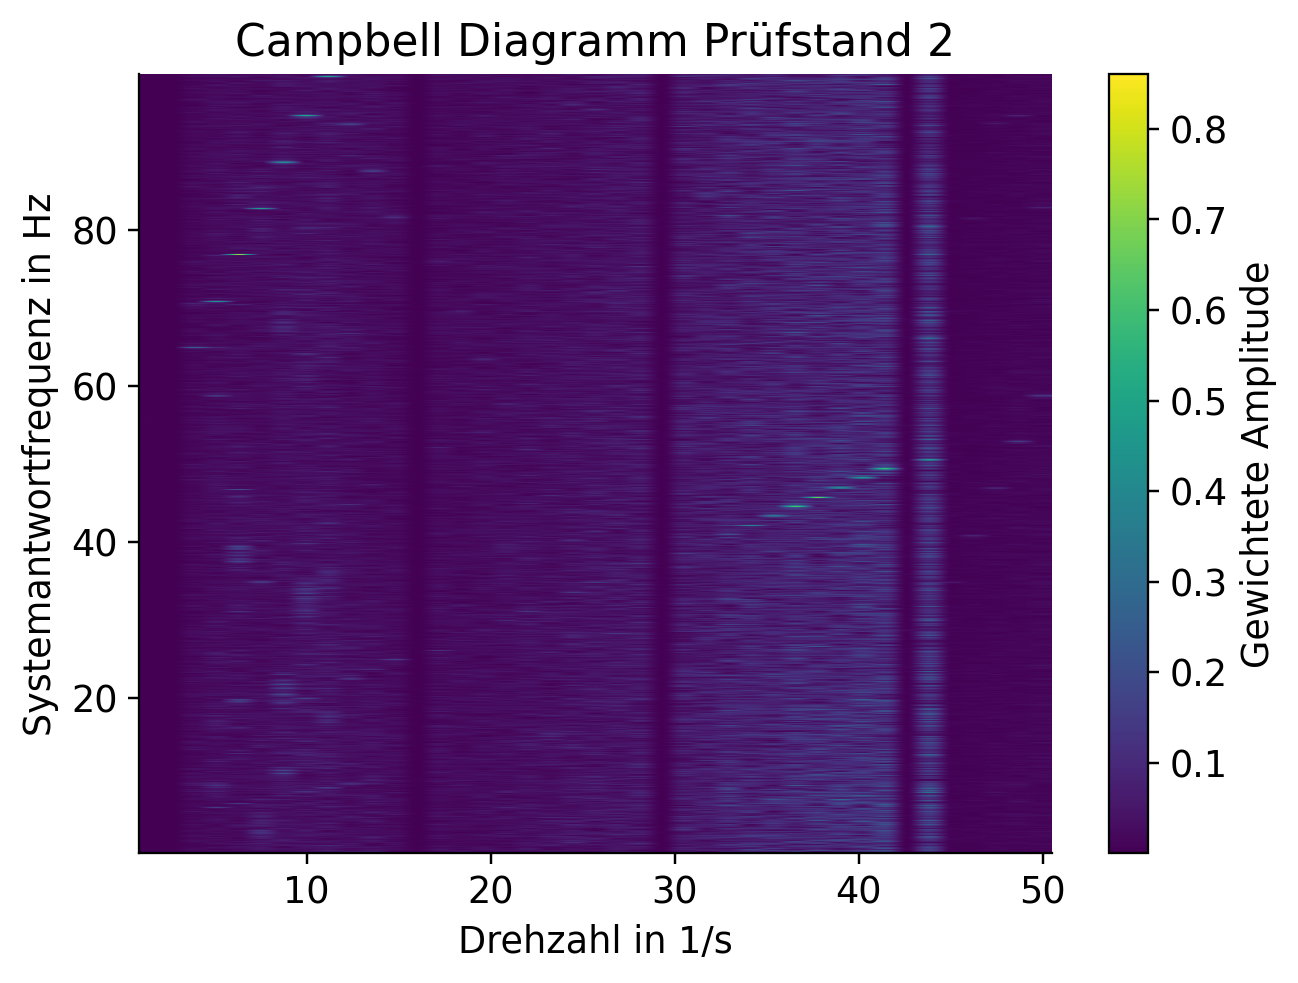

In [15]:
amplitude_spectrums_array = np.array(amplitude_spectrums)
frequencies_array = np.array(frequencies)
rpm_array = np.array(rpm)

#Erstellen Sie eine leere Matrix für die Verlaufsdarstellung
Amp_matrix = np.zeros((len(frequencies_array[0]),len(rpm_array) ))

#Iterieren Sie über jede Zeile der Matrix von der Verlaufsdarstellung und füllt Sie sie mit den Amplitudenwerten
for i in range(len(rpm_array)):
    for j in range(len(frequencies_array[i])):
        Amp_matrix[j, i] += amplitude_spectrums_array[i, j]

#Diagramm erstellen
fig = plt.figure()
plt.imshow(Amp_matrix, aspect='auto', origin='lower', extent=[rpm_array.min(), rpm_array.max(),frequencies_array.min(), frequencies_array.max()], vmin=Amp_matrix.min(), vmax=Amp_matrix.max(), cmap='viridis')
plt.title('Campbell Diagramm Prüfstand 2')
plt.xlabel('Drehzahl in 1/s')
plt.ylabel('Systemantwortfrequenz in Hz')
plt.colorbar(label='Gewichtete Amplitude')
plt.show

## Dritter Datensatz: Prüfstand #4

#### 1. Einlesen der Mess- und Metadaten

In [16]:
#1a angabe Pfad/Dateiname
path_measurement_folder = os.path.join("/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240123_140859_lavalrotor_12_03.h5"  # name of the H5-file

#1b auslesen Metadaten
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalroto

#### 2. Verarbeitung der Messdaten

In [17]:
importlib.reload(m_postprocessing)  # reload functions

#Pfad zu h5 datei
h5_file_path = "/home/pi/lavalrotor_laboratory/measurement_data/data_20240123_140859_lavalrotor_12_03/data_20240123_140859_lavalrotor_12_03.h5"#"f"{path_measurement_folde}/{filename}"#"/

#Datenlisten von h5 Datei
#acceleration_x =[]
#acceleration_y =[]
#acceleration_z =[]
#time =[]
rpm =[]

acc_inter = []
amplitude_spectrums = []
frequencies = []

#h5 Datei auslesen 
with h5py.File(h5_file_path, "r") as file:
    for exp_stamp in file.keys():
        experiment_group = file[exp_stamp]["RawData"]#auslesen aller 20 messpunkte per schleife

        data_group = experiment_group[uuid_acceleration]
        acceleration_x = np.array(data_group["acceleration_x"])
        acceleration_y = np.array(data_group["acceleration_y"])
        acceleration_z = np.array(data_group["acceleration_z"])
        time = np.array(data_group["timestamp"])
        
        rpm_point = experiment_group[uuid_motor_rpm]["motor_rpm"][()]
        rpm.append(rpm_point/60)
        #verwendung der postprocessing fkts
        acc_point = m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
        acc_interpolated = m_postprocessing.interpolation(time,acc_point,interpolation_points)
        acc_inter.append(acc_interpolated)
        amplitude_spectrum_point, frequency_point = m_postprocessing.my_fft_scaled(acc_interpolated, interpolation_points)
        amplitude_spectrums.append(amplitude_spectrum_point[1:])
        frequencies.append(frequency_point[1:])

#### 3. Darstellung mittels Campbell-Diagramm

<function matplotlib.pyplot.show(close=None, block=None)>

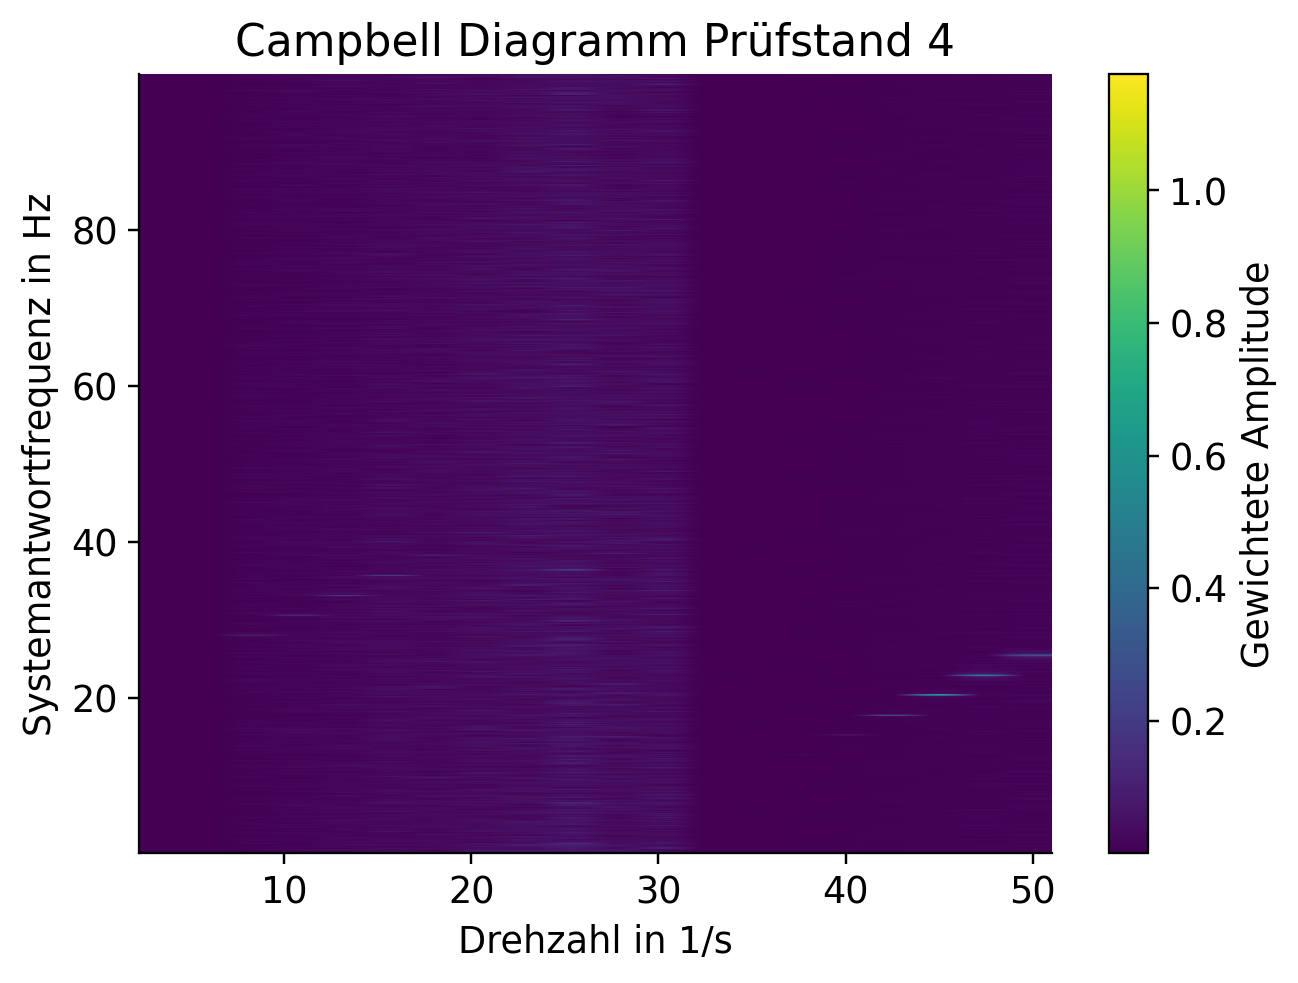

In [18]:
amplitude_spectrums_array = np.array(amplitude_spectrums)
frequencies_array = np.array(frequencies)
rpm_array = np.array(rpm)

#Erstellen Sie eine leere Matrix für die Verlaufsdarstellung
Amp_matrix = np.zeros((len(frequencies_array[0]),len(rpm_array) ))

#Iterieren Sie über jede Zeile der Matrix von der Verlaufsdarstellung und füllt Sie sie mit den Amplitudenwerten
for i in range(len(rpm_array)):
    for j in range(len(frequencies_array[i])):
        Amp_matrix[j, i] += amplitude_spectrums_array[i, j]

#Diagramm erstellen
fig = plt.figure()
plt.imshow(Amp_matrix, aspect='auto', origin='lower', extent=[rpm_array.min(), rpm_array.max(),frequencies_array.min(), frequencies_array.max()], vmin=Amp_matrix.min(), vmax=Amp_matrix.max(), cmap='viridis')
plt.title('Campbell Diagramm Prüfstand 4')
plt.xlabel('Drehzahl in 1/s')
plt.ylabel('Systemantwortfrequenz in Hz')
plt.colorbar(label='Gewichtete Amplitude')
plt.show

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Mithilfe der Campbell Diagramme lassen sich die rotordynamischen Stabilitäten der verschiedenen Prüfstände beschreiben. Bei Betrachtung der Ergebnisse von Prüfstand 3 lässt sich sagen, dass dieser bei ca 1000 rpm  starke Vibrationen erzeugt.
Dies würde auch mit unserer vorab berechneten kritischen Drehzahl übereinstimmen, welche bei 1061,04 rpm liegt. Nach überschreiten der kritischen Drehzahl lassen die Vibrationen wieder nach und der Versuchsauf läuft ruhiger ab. Dies liegt daran das sich dann die Scheibe selbst zentriert. Somit kann man sagen das der Prüfstand 3 für höhere Drehzahlen ausgelegt ist und dort ruhiger läuft.Anhand des Campbell Diagramms  der anderen zwei Prüfstände sieht man am jeweiligen Amplitudenausschlag, dass diese andere stabile Betriebsbereiche besitzen. Zum Beispiel weisst der Prüfstand 2 den niedrigsten Vibrationsstabilen Betriebsbereich auf.
Die unterschiedlichen Messergebnisse und Beobachtungen bei dem ausführen der Versuche lässt sich nur auf den Aufbau und die verwendeten Massen zurück führen. Wenn man die Metadaten der Prüfstände genbauer betrachtet bestätigt sich auch diese Vermutung, denn die Massenscheiben variieren bei jedem Versuchsstand. Teststand 3 besitzt eine Masse von 950g während Teststand 2 eine Masse von 500g und Teststannd 4 eine Masse von 1kg besitzt, diese unterschiedlichen Masse spieglt ich auch in den kritischen Drehzahlen und Amplitudenausschlägen im Campbell Diagramm wieder.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Während des Laborversuchs wurden als Vergleich auch die kritischen Drehzahlen händisch berechnet, dabei wurde folgendermaasen vorgegangen. Zuerst wurde mithilfe der Scheibenmasse, der Ersatzfedersteigigkeit und ees Abstandsverhältnisses zwischen Scheibe und Lager die Kritische Kreisfrequenz berechnet. Diese beträgt bei Prüfstand 3 111,1 [1/s]. Mit der Kreisfrequenz wurde danach die Kritische Drehzahl von 1061,04 rpm bestimmt. Wenn man nun das Campbell Diagramm nochmal genauer betrachtet kann man erkennen das ab dieser Frequenz(als Anregungsfrequenz) eine erhöhte Amplitude auftritt und somit größere Schwingungen auftreten.
Zuisammenfassend lässt sich also sagen,dass die experimentell bestimmte kritische Drehzahl ungefähr mit der berechneten kritischen Drehzahl übereinstimmt und der Versuch unter einigen Breücksichtigung einiger kleiner Abweichungen die Theorie gut wiederspiegelt.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Rückblickend fande ich den Laborversuch sehr interessant, da er einfach umzusetzen war und man dadurch noch genug Zeit hatte sich in der Gruppe über die Beobachtungen und Messwerte auszutauschen.Dennoch fande ich das die Auswertung des Versuchs dieses mal deutlich anspruchsvoller aus Beispielsweise beim Küchentischversuch war und einem beim Bearbeiten teilweise nicht 100% klar war wie man am besten weiter vorgeht.

Allgemein lässt sich positiv hervorheben, dass das PD Team im Verlauf des Praktikums einen gut Betreut hat und auch auf das Feedback der Studierenden bezüglich des Arbeitsumfangs eingegangen ist.